In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow_addons as tfa

import os
import re
import numpy as np
import pandas as pd
import pickle
import random
import collections
import json
from datetime import datetime

import sentencepiece as spm
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

### Utilizations

In [2]:
def print_json_tree(data, indent=""):
    for key, value in data.items():
        if type(value) == list:
            print(f'{indent}- {key}: [{len(value)}]')
            print_json_tree(value[0], indent + "  ")
        else:
            print(f'{indent}- {key}: {value}')

In [3]:
def print_file(filename, count=10):
    with open(filename) as f:
        for i, line in enumerate(f):
            if count <= i:
                break
            print(line.strip())

In [4]:
def get_pad_mask(tokens, i_pad=0):
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask

In [5]:
def get_ahead_mask(tokens, i_pad=0):
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask

In [6]:
@tf.function(experimental_relax_shapes=True)
def gelu(x):
    return 0.5 * x * (1 + K.tanh(x * 0.7978845608 * (1 + 0.044715 * x * x)))

In [7]:
def kernel_initializer(stddev=0.02):
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)

In [8]:
def bias_initializer():
    return tf.zeros_initializer

In [9]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

# Source Code_Non Pretrained Model

### Load Data

In [10]:
data_dir = os.getenv('HOME')+'/aiffel/bert_qna/data'
model_dir = os.getenv('HOME')+'/aiffel/bert_qna/models'

In [11]:
train_json_path = data_dir + '/KorQuAD_v1.0_train.json'
with open(train_json_path) as f:
    train_json = json.load(f)
    print_json_tree(train_json)

- version: KorQuAD_v1.0_train
- data: [1420]
  - paragraphs: [3]
    - qas: [8]
      - answers: [1]
        - text: 교향곡
        - answer_start: 54
      - id: 6566495-0-0
      - question: 바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
    - context: 1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
  - title: 파우스트_서곡


In [12]:
dev_json_path = data_dir + '/KorQuAD_v1.0_dev.json'
with open(dev_json_path) as f:
    dev_json = json.load(f)
    print_json_tree(dev_json)

- version: KorQuAD_v1.0_dev
- data: [140]
  - paragraphs: [2]
    - qas: [7]
      - answers: [1]
        - text: 1989년 2월 15일
        - answer_start: 0
      - id: 6548850-0-0
      - question: 임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
    - context: 1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
  - title: 임종석


### Data Preprocessing

In [13]:
def _is_whitespace(c):
    if c == " " or c == "\t" or c == "\r" or c == "\n" or ord(c) == 0x202F:
        return True
    return False

In [14]:
def _tokenize_whitespace(string):
    word_tokens = []
    char_to_word = []
    prev_is_whitespace = True

    for c in string:
        if _is_whitespace(c):
            prev_is_whitespace = True
        else:
            if prev_is_whitespace:
                word_tokens.append(c)
            else:
                word_tokens[-1] += c
            prev_is_whitespace = False    
        char_to_word.append(len(word_tokens) - 1)
    
    return word_tokens, char_to_word

In [15]:
def _tokenize_vocab(vocab, context_words):
    word_to_token = []
    context_tokens = []
    for (i, word) in enumerate(context_words):
        word_to_token.append(len(context_tokens))
        tokens = vocab.encode_as_pieces(word)
        for token in tokens:
            context_tokens.append(token)
    return context_tokens, word_to_token

In [16]:
def _improve_span(vocab, context_tokens, token_start, token_end, char_answer):
    token_answer = " ".join(vocab.encode_as_pieces(char_answer))
    for new_start in range(token_start, token_end + 1):
        for new_end in range(token_end, new_start - 1, -1):
            text_span = " ".join(context_tokens[new_start : (new_end + 1)])
            if text_span == token_answer:
                return (new_start, new_end)
    return (token_start, token_end)

In [17]:
def dump_korquad(vocab, json_data, out_file):
    with open(out_file, "w") as f:
        for data in tqdm(json_data["data"]):
            title = data["title"]
            for paragraph in data["paragraphs"]:
                context = paragraph["context"]
                context_words, char_to_word = _tokenize_whitespace(context)

                for qa in paragraph["qas"]:
                    assert len(qa["answers"]) == 1
                    qa_id = qa["id"]
                    question = qa["question"]
                    answer_text = qa["answers"][0]["text"]
                    answer_start = qa["answers"][0]["answer_start"]
                    answer_end = answer_start + len(answer_text) - 1

                    assert answer_text == context[answer_start:answer_end + 1]

                    word_start = char_to_word[answer_start]
                    word_end = char_to_word[answer_end]

                    word_answer = " ".join(context_words[word_start:word_end + 1])
                    char_answer = " ".join(answer_text.strip().split())
                    assert char_answer in word_answer

                    context_tokens, word_to_token = _tokenize_vocab(vocab, context_words)

                    token_start = word_to_token[word_start]
                    if word_end < len(word_to_token) - 1:
                        token_end = word_to_token[word_end + 1] - 1
                    else:
                        token_end = len(context_tokens) - 1

                    token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, char_answer)

                    data = {"qa_id": qa_id, "title": title, "question": vocab.encode_as_pieces(question), "context": context_tokens, "answer": char_answer, "token_start": token_start, "token_end":token_end}
                    f.write(json.dumps(data, ensure_ascii=False))
                    f.write("\n")

In [18]:
def load_data(args, filename):
    inputs, segments, labels_start, labels_end = [], [], [], []

    n_discard = 0
    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, desc=f"Loading ...")):
            data = json.loads(line)
            token_start = data.get("token_start")
            token_end = data.get("token_end")
            question = data["question"][:args.max_query_length]
            context = data["context"]
            answer_tokens = " ".join(context[token_start:token_end + 1])
            context_len = args.max_seq_length - len(question) - 3

            if token_end >= context_len:
                n_discard += 1
                continue
            context = context[:context_len]
            assert len(question) + len(context) <= args.max_seq_length - 3

            tokens = ['[CLS]'] + question + ['[SEP]'] + context + ['[SEP]']
            ids = [vocab.piece_to_id(token) for token in tokens]
            ids += [0] * (args.max_seq_length - len(ids))
            inputs.append(ids)
            segs = [0] * (len(question) + 2) + [1] * (len(context) + 1)
            segs += [0] * (args.max_seq_length - len(segs))
            segments.append(segs)
            token_start += (len(question) + 2)
            labels_start.append(token_start)
            token_end += (len(question) + 2)
            labels_end.append(token_end)
    print(f'n_discard: {n_discard}')

    return (np.array(inputs), np.array(segments)), (np.array(labels_start), np.array(labels_end))

In [19]:
vocab = spm.SentencePieceProcessor()
vocab.load(f"{model_dir}/ko_32000.model")

True

In [20]:
context = train_json['data'][0]['paragraphs'][0]['context']
question = train_json['data'][0]['paragraphs'][0]['qas'][0]['question']
answer_text = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['text']
answer_start = train_json['data'][0]['paragraphs'][0]['qas'][0]['answers'][0]['answer_start']
answer_end = answer_start + len(answer_text) - 1

print('[context] ', context)
print('[question] ', question)
print('[answer] ', answer_text)
print('[answer_start] index: ', answer_start, 'character: ', context[answer_start])
print('[answer_end]index: ', answer_end, 'character: ', context[answer_end])

assert context[answer_start:answer_end + 1] == answer_text

[context]  1839년 바그너는 괴테의 파우스트을 처음 읽고 그 내용에 마음이 끌려 이를 소재로 해서 하나의 교향곡을 쓰려는 뜻을 갖는다. 이 시기 바그너는 1838년에 빛 독촉으로 산전수전을 다 걲은 상황이라 좌절과 실망에 가득했으며 메피스토펠레스를 만나는 파우스트의 심경에 공감했다고 한다. 또한 파리에서 아브네크의 지휘로 파리 음악원 관현악단이 연주하는 베토벤의 교향곡 9번을 듣고 깊은 감명을 받았는데, 이것이 이듬해 1월에 파우스트의 서곡으로 쓰여진 이 작품에 조금이라도 영향을 끼쳤으리라는 것은 의심할 여지가 없다. 여기의 라단조 조성의 경우에도 그의 전기에 적혀 있는 것처럼 단순한 정신적 피로나 실의가 반영된 것이 아니라 베토벤의 합창교향곡 조성의 영향을 받은 것을 볼 수 있다. 그렇게 교향곡 작곡을 1839년부터 40년에 걸쳐 파리에서 착수했으나 1악장을 쓴 뒤에 중단했다. 또한 작품의 완성과 동시에 그는 이 서곡(1악장)을 파리 음악원의 연주회에서 연주할 파트보까지 준비하였으나, 실제로는 이루어지지는 않았다. 결국 초연은 4년 반이 지난 후에 드레스덴에서 연주되었고 재연도 이루어졌지만, 이후에 그대로 방치되고 말았다. 그 사이에 그는 리엔치와 방황하는 네덜란드인을 완성하고 탄호이저에도 착수하는 등 분주한 시간을 보냈는데, 그런 바쁜 생활이 이 곡을 잊게 한 것이 아닌가 하는 의견도 있다.
[question]  바그너는 괴테의 파우스트를 읽고 무엇을 쓰고자 했는가?
[answer]  교향곡
[answer_start] index:  54 character:  교
[answer_end]index:  56 character:  곡


In [21]:
word_tokens, char_to_word = _tokenize_whitespace(context)

print( word_tokens[:20])

char_to_word[:20], context[:20]

['1839년', '바그너는', '괴테의', '파우스트을', '처음', '읽고', '그', '내용에', '마음이', '끌려', '이를', '소재로', '해서', '하나의', '교향곡을', '쓰려는', '뜻을', '갖는다.', '이', '시기']


([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 3],
 '1839년 바그너는 괴테의 파우스트을')

In [22]:
context_tokens, word_to_token = _tokenize_vocab(vocab, word_tokens)
for i in range(min(20, len(word_to_token) - 1)):
    print(word_to_token[i], context_tokens[word_to_token[i]:word_to_token[i + 1]])

0 ['▁1839', '년']
2 ['▁바그너', '는']
4 ['▁괴테', '의']
6 ['▁', '파우스트', '을']
9 ['▁처음']
10 ['▁읽고']
11 ['▁그']
12 ['▁내용에']
13 ['▁마음이']
14 ['▁끌려']
15 ['▁이를']
16 ['▁소재로']
17 ['▁해서']
18 ['▁하나의']
19 ['▁교향곡', '을']
21 ['▁쓰', '려는']
23 ['▁뜻을']
24 ['▁갖는다', '.']
26 ['▁이']
27 ['▁시기']


In [23]:
word_start = char_to_word[answer_start]
word_end = char_to_word[answer_end]
word_start, word_end, answer_text, word_tokens[word_start:word_end + 1]

(14, 14, '교향곡', ['교향곡을'])

In [24]:
token_start = word_to_token[word_start]
if word_end < len(word_to_token) - 1:
    token_end = word_to_token[word_end + 1] - 1
else:
    token_end = len(context_tokens) - 1
token_start, token_end, context_tokens[token_start:token_end + 1]

(19, 20, ['▁교향곡', '을'])

In [25]:
token_answer = " ".join(vocab.encode_as_pieces(answer_text))
token_answer

'▁교향곡'

In [26]:
for new_start in range(token_start, token_end + 1):
    for new_end in range(token_end, new_start - 1, -1):
        text_span = " ".join(context_tokens[new_start : (new_end + 1)])
        if text_span == token_answer:
            print("O >>", (new_start, new_end), text_span)
        else:
            print("X >>", (new_start, new_end), text_span)

X >> (19, 20) ▁교향곡 을
O >> (19, 19) ▁교향곡
X >> (20, 20) 을


In [27]:
token_start, token_end = _improve_span(vocab, context_tokens, token_start, token_end, answer_text)
print('token_start:', token_start, ' token_end:', token_end)
context_tokens[token_start:token_end + 1]

token_start: 19  token_end: 19


['▁교향곡']

### Separate Dataset

In [28]:
dump_korquad(vocab, train_json, f"{data_dir}/korquad_train.json")
dump_korquad(vocab, dev_json, f"{data_dir}/korquad_dev.json")

  0%|          | 0/1420 [00:00<?, ?it/s]

  0%|          | 0/140 [00:00<?, ?it/s]

In [29]:
train_json = os.path.join(data_dir, "korquad_train.json")
dev_json = os.path.join(data_dir, "korquad_dev.json")

In [30]:
args = Config({
    'max_seq_length': 384,
    'max_query_length': 64,
})
args

{'max_seq_length': 384, 'max_query_length': 64}

In [31]:
train_inputs, train_labels = load_data(args, train_json)
print(f"train_inputs: {train_inputs[0].shape}")
print(f"train_inputs: {train_inputs[1].shape}")
print(f"train_labels: {train_labels[0].shape}")
print(f"train_labels: {train_labels[1].shape}")

dev_inputs, dev_labels = load_data(args, dev_json)
print(f"dev_inputs: {dev_inputs[0].shape}")
print(f"dev_inputs: {dev_inputs[1].shape}")
print(f"dev_labels: {dev_labels[0].shape}")
print(f"dev_labels: {dev_labels[1].shape}")

train_inputs[:10], train_labels[:10]

Loading ...: 0it [00:00, ?it/s]

n_discard: 430
train_inputs: (59977, 384)
train_inputs: (59977, 384)
train_labels: (59977,)
train_labels: (59977,)


Loading ...: 0it [00:00, ?it/s]

n_discard: 78
dev_inputs: (5696, 384)
dev_inputs: (5696, 384)
dev_labels: (5696,)
dev_labels: (5696,)


((array([[    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    10, ...,     0,     0,     0],
         [    5, 15798,    19, ...,     0,     0,     0],
         ...,
         [    5, 21666,    19, ...,     0,     0,     0],
         [    5,   964, 16865, ...,     0,     0,     0],
         [    5,   365,    15, ...,     0,     0,     0]]),
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]])),
 (array([ 37, 184,  98, ...,  74, 190,  35]),
  array([ 37, 185, 102, ...,  75, 191,  44])))

### Modeling

In [32]:
class Config(dict):
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

In [33]:
class SharedEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="weight_shared_embedding"):
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        if mode == "embedding":
            return self._embedding(inputs)
        elif mode == "linear":
            return self._linear(inputs)
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])
        return outputs

In [34]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, config, name="position_embedding"):
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed

In [35]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    def __init__(self, name="scale_dot_product_attention"):
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, config, name="multi_head_attention"):
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

        self.attention = ScaleDotProductAttention(name="self_attention")

        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)

        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])
        attn_out = self.W_O(attn_out)

        return attn_out

In [37]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    def __init__(self, config, name="feed_forward"):
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

In [38]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, config, name="encoder_layer"):
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out

In [39]:
class BERT(tf.keras.layers.Layer):
    def __init__(self, config, name="bert"):
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionalEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, enc_tokens, segments):
        enc_self_mask = get_pad_mask(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = enc_out
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed

In [40]:
class BERT4KorQuAD(tf.keras.Model):
    def __init__(self, config):
        super().__init__(name='BERT4KorQuAD')

        self.bert = BERT(config)
        self.dense = tf.keras.layers.Dense(2)
    
    def call(self, enc_tokens, segments):
        logits_cls, logits_lm = self.bert(enc_tokens, segments)

        hidden = self.dense(logits_lm)
        start_logits, end_logits = tf.split(hidden, 2, axis=-1)

        start_logits = tf.squeeze(start_logits, axis=-1)
        start_outputs = tf.keras.layers.Softmax(name="start")(start_logits)

        end_logits = tf.squeeze(end_logits, axis=-1)
        end_outputs = tf.keras.layers.Softmax(name="end")(end_logits)

        return start_outputs, end_outputs

In [41]:
config = Config({"d_model": 512, "n_head": 8, "d_head": 64, "dropout": 0.1, "d_ff": 1024, "layernorm_epsilon": 0.001, "n_layer": 6, "n_seq": 384, "n_vocab": 0, "i_pad": 0})
config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()
config

{'d_model': 512,
 'n_head': 8,
 'd_head': 64,
 'dropout': 0.1,
 'd_ff': 1024,
 'layernorm_epsilon': 0.001,
 'n_layer': 6,
 'n_seq': 384,
 'n_vocab': 32007,
 'i_pad': 0}

In [42]:
bert_batch_size = 32 

train_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_labels)).shuffle(10000).batch(bert_batch_size)
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_inputs, dev_labels)).batch(bert_batch_size)

In [43]:
model = BERT4KorQuAD(config)

### Training

In [44]:
def train_epoch(model, dataset, loss_fn, acc_fn, optimizer):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    p_bar = tqdm(dataset)
    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(p_bar):
        with tf.GradientTape() as tape:
            start_outputs, end_outputs = model(enc_tokens, segments)

            start_loss = loss_fn(start_labels, start_outputs)
            end_loss = loss_fn(end_labels, end_outputs)
            loss = start_loss + end_loss

            start_acc = acc_fn(start_labels, start_outputs)
            end_acc = acc_fn(end_labels, end_outputs)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)
        if batch % 10 == 9:
            p_bar.set_description(f'loss: {metric_start_loss.result():0.4f}, {metric_end_loss.result():0.4f}, acc: {metric_start_acc.result():0.4f}, {metric_end_acc.result():0.4f}')
    p_bar.close()

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [45]:
def eval_epoch(model, dataset, loss_fn, acc_fn):
    metric_start_loss = tf.keras.metrics.Mean(name='start_loss')
    metric_end_loss = tf.keras.metrics.Mean(name='end_loss')
    metric_start_acc = tf.keras.metrics.Mean(name='start_acc')
    metric_end_acc = tf.keras.metrics.Mean(name='end_acc')

    for batch, ((enc_tokens, segments), (start_labels, end_labels)) in enumerate(dataset):
        start_outputs, end_outputs = model(enc_tokens, segments)

        start_loss = loss_fn(start_labels, start_outputs)
        end_loss = loss_fn(end_labels, end_outputs)

        start_acc = acc_fn(start_labels, start_outputs)
        end_acc = acc_fn(end_labels, end_outputs)

        metric_start_loss(start_loss)
        metric_end_loss(end_loss)
        metric_start_acc(start_acc)
        metric_end_acc(end_acc)

    return metric_start_loss.result(), metric_end_loss.result(), metric_start_acc.result(), metric_end_acc.result()

In [46]:
start_loss_list, end_loss_list, start_acc_list, end_acc_list = [], [], [], []

loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    start_loss_list.append(f'{start_loss:0.4f}')
    end_loss_list.append(f'{end_loss:0.4f}')
    start_acc_list.append(f'{start_acc:0.4f}')
    end_acc_list.append(f'{end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 3.7694, 4.3599, acc: 0.1208, 0.0873
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 5.9506, 5.9506, acc: 0.0102, 0.0111


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 5.9506, 5.9506, acc: 0.0025, 0.0091


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 5.9506, 5.9507, acc: 0.0223, 0.0035
early stopping


In [47]:
non_pretrained_df = pd.DataFrame({'start_loss': start_loss_list,
                                  'end_loss': end_loss_list,
                                  'start_acc': start_acc_list,
                                  'end_acc': end_acc_list})
non_pretrained_df

,start_loss,end_loss,start_acc,end_acc
0,3.7694,4.3599,0.1208,0.0873
1,5.9506,5.9506,0.0102,0.0111
2,5.9506,5.9506,0.0025,0.0091
3,5.9506,5.9507,0.0223,0.0035


# Source Code_Pretrained Model

### Load Model

In [48]:
checkpoint_file = os.path.join(model_dir, 'bert_pretrain_32000.hdf5')

model = BERT4KorQuAD(config)

if os.path.exists(checkpoint_file):
    enc_tokens = np.random.randint(0, len(vocab), (4, 10))
    segments = np.random.randint(0, 2, (4, 10))
    model(enc_tokens, segments)
 
    model.load_weights(os.path.join(model_dir, "bert_pretrain_32000.hdf5"), by_name=True)

    model.summary()
else:
    print('NO Pretrained Model')

Model: "BERT4KorQuAD"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (BERT)                  multiple                  29202944  
_________________________________________________________________
dense_73 (Dense)             multiple                  1026      
Total params: 29,203,970
Trainable params: 29,203,970
Non-trainable params: 0
_________________________________________________________________


### Finetune

In [49]:
start_loss_list, end_loss_list, start_acc_list, end_acc_list = [], [], [], []

loss_fn = tf.keras.losses.sparse_categorical_crossentropy
acc_fn = tf.keras.metrics.sparse_categorical_accuracy

optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

best_acc = .0
patience = 0
for epoch in range(10):
    train_epoch(model, train_dataset, loss_fn, acc_fn, optimizer)
    start_loss, end_loss, start_acc, end_acc = eval_epoch(model, dev_dataset, loss_fn, acc_fn)
    print(f'eval {epoch} >> loss: {start_loss:0.4f}, {end_loss:0.4f}, acc: {start_acc:0.4f}, {end_acc:0.4f}')
    start_loss_list.append(f'{start_loss:0.4f}')
    end_loss_list.append(f'{end_loss:0.4f}')
    start_acc_list.append(f'{start_acc:0.4f}')
    end_acc_list.append(f'{end_acc:0.4f}')
    acc = start_acc + end_acc
    if best_acc < acc:
        patience = 0
        best_acc = acc
        model.save_weights(os.path.join(data_dir, "korquad_bert_none_pretrain.hdf5"))
        print(f'save best model')
    else:
        patience += 1
    if 3 <= patience:
        print(f'early stopping')
        break

  0%|          | 0/1875 [00:00<?, ?it/s]

eval 0 >> loss: 1.7426, 1.9907, acc: 0.5453, 0.5139
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 1 >> loss: 1.6810, 1.8979, acc: 0.5664, 0.5323
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 2 >> loss: 1.8611, 2.2828, acc: 0.5758, 0.5355
save best model


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 3 >> loss: 2.3958, 2.5332, acc: 0.5597, 0.5142


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 4 >> loss: 2.1631, 2.3696, acc: 0.5530, 0.5109


  0%|          | 0/1875 [00:00<?, ?it/s]

eval 5 >> loss: 2.1665, 2.6157, acc: 0.5393, 0.5070
early stopping


In [51]:
pretrained_df = pd.DataFrame({'start_loss': start_loss_list,
                                  'end_loss': end_loss_list,
                                  'start_acc': start_acc_list,
                                  'end_acc': end_acc_list})
pretrained_df

,start_loss,end_loss,start_acc,end_acc
0,1.7426,1.9907,0.5453,0.5139
1,1.6810,1.8979,0.5664,0.5323
2,1.8611,2.2828,0.5758,0.5355
3,2.3958,2.5332,0.5597,0.5142
4,2.1631,2.3696,0.5530,0.5109
5,2.1665,2.6157,0.5393,0.5070


### Inference

In [52]:
def do_predict(model, question, context):
    q_tokens = vocab.encode_as_pieces(question)[:args.max_query_length]
    c_tokens = vocab.encode_as_pieces(context)[:args.max_seq_length - len(q_tokens) - 3]
    
    tokens = ['[CLS]'] + q_tokens + ['[SEP]'] + c_tokens + ['[SEP]']
    token_ids = [vocab.piece_to_id(token) for token in tokens]
    
    segments = [0] * (len(q_tokens) + 2) + [1] * (len(c_tokens) + 1)

    y_start, y_end = model(np.array([token_ids]), np.array([segments]))

    y_start_idx = K.argmax(y_start, axis=-1)[0].numpy()
    y_end_idx = K.argmax(y_end, axis=-1)[0].numpy()
    answer_tokens = tokens[y_start_idx:y_end_idx + 1]

    return vocab.decode_pieces(answer_tokens)

In [53]:
dev_json = os.path.join(data_dir, "korquad_dev.json")

with open(dev_json) as f:
    for i, line in enumerate(f):
        data = json.loads(line)
        question = vocab.decode_pieces(data['question'])
        context = vocab.decode_pieces(data['context'])
        answer = data['answer']
        answer_predict = do_predict(model, question, context)
        if answer in answer_predict:
            print(i)
            print("질문 : ", question)
            print("지문 : ", context)
            print("정답 : ", answer)
            print("예측 : ", answer_predict, "\n")
        if 100 < i:
            break

0
질문 :  임종석이 여의도 농민 폭력 시위를 주도한 혐의로 지명수배 된 날은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임종석을 발견, 검거해 구속을 집행했다. 임종석은 청량리경찰서에서 약 1시간 동안 조사를 받은 뒤 오전 9시 50분 경 서울 장안동의 서울지방경찰청 공안분실로 인계되었다.
정답 :  1989년 2월 15일
예측 :  1989년 2월 15일 

1
질문 :  1989년 6월 30일 평양축전에 대표로 파견 된 인물은?
지문 :  1989년 2월 15일 여의도 농민 폭력 시위를 주도한 혐의(폭력행위등처벌에관한법률위반)으로 지명수배되었다. 1989년 3월 12일 서울지방검찰청 공안부는 임종석의 사전구속영장을 발부받았다. 같은 해 6월 30일 평양축전에 임수경을 대표로 파견하여 국가보안법위반 혐의가 추가되었다. 경찰은 12월 18일~20일 사이 서울 경희대학교에서 임종석이 성명 발표를 추진하고 있다는 첩보를 입수했고, 12월 18일 오전 7시 40분 경 가스총과 전자봉으로 무장한 특공조 및 대공과 직원 12명 등 22명의 사복 경찰을 승용차 8대에 나누어 경희대학교에 투입했다. 1989년 12월 18일 오전 8시 15분 경 서울청량리경찰서는 호위 학생 5명과 함께 경희대학교 학생회관 건물 계단을 내려오는 임

30
질문 :  헤이그가 군에서 퇴역한 년도는 몇년도입니까?
지문 :  헤이그는 닉슨 대통령이 그를 사성 장군과 육군 부참모로 진급시킬 때 집중 광선과 논쟁으로 들어갔다. 헤이그를 군사의 최상으로 밀어넣은 닉슨의 행동은 대통령의 남자들을 다양한 연방 대리법에서 권한의 직우들로 놓은 노력과 함께 일치였다. 하지만 그는 곧 백악관으로 돌아가 1973년부터 1974년까지 대통령 특별 보좌관을 지냈다. 워터게이트 사건이 일어난지 한달 후, 헤이그는 포위된 닉슨 대통령을 위한 치명적 역할을 하였다. 그일은 8월 닉슨의 사임과 제럴드 포드의 대통령으로 계승으로 이끈 협상들에서 헤이그가 수단이었던 우연이 아니었다. 곧 후에 헤이그는 미국 유럽 연합군 최고사령부의 최고 사령관으로 임명되었다. 그는 나토에서 다음 5년을 보내고 1979년 군에서 퇴역하여 미국 기술 주식 회사의 우두머리가 되었다.
정답 :  1979년
예측 :  5년을 보내고 1979년 

32
질문 :  헤이그가 군대에서 퇴역한 년도는?
지문 :  헤이그는 닉슨 대통령이 그를 사성 장군과 육군 부참모로 진급시킬 때 집중 광선과 논쟁으로 들어갔다. 헤이그를 군사의 최상으로 밀어넣은 닉슨의 행동은 대통령의 남자들을 다양한 연방 대리법에서 권한의 직우들로 놓은 노력과 함께 일치였다. 하지만 그는 곧 백악관으로 돌아가 1973년부터 1974년까지 대통령 특별 보좌관을 지냈다. 워터게이트 사건이 일어난지 한달 후, 헤이그는 포위된 닉슨 대통령을 위한 치명적 역할을 하였다. 그일은 8월 닉슨의 사임과 제럴드 포드의 대통령으로 계승으로 이끈 협상들에서 헤이그가 수단이었던 우연이 아니었다. 곧 후에 헤이그는 미국 유럽 연합군 최고사령부의 최고 사령관으로 임명되었다. 그는 나토에서 다음 5년을 보내고 1979년 군에서 퇴역하여 미국 기술 주식 회사의 우두머리가 되었다.
정답 :  1979년
예측 :  5년을 보내고 1979년 

34
질문 :  알렉산더 헤이그는 레이건의 조언자들을 무엇이라고 묘사하였는가?
지문 :  그의 편

57
질문 :  극보수주의계열의 기독교이자 아직도 노아의 홍수가 있었다고 주장하는 곳은 어디인가?
지문 :  역사학과 과학의 발달이 더뎠던 고대사회에서는, 성경이 단순한 교리적인 부분 뿐 아니라 역사책으로서의 권위도 높았기에 노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이 남아 있을것이라고 주장하며 노아의 방주를 찾기 위한 노력을 했다고 주장한다. 이들은 같은 메소포타미아 지방의 신화인 이슬람교 경전이나 길가메쉬 서사시등의 신화를 들어서 이를 근거라고 주장하기도 했다. 그러나 이러한 전통적 근본주의적 시각은 과거에는 상당히 힘을 얻었으나, 역사학과 과학의 발달에 따라 힘을 잃게 되었고, 홍수지질학은 유사과학으로서 남게 되었다. 현대에는 뒤의 실존논란에서 다루는 것처럼 이러한 근본주의적 해석은 비과학적인 해석으로 여기는 것이 일반적이지만, 남침례교로 대표되는 극보수주의계열 기독교에서는 아직도 이것이 받아들여지고 있다.
정답 :  남침례교
예측 :  남침례교로 

58
질문 :  고대사회에서 성경은 교리를 다루는 책일 뿐만 아니라 어떤 책으로도 권위가 상당했는가?
지문 :  역사학과 과학의 발달이 더뎠던 고대사회에서는, 성경이 단순한 교리적인 부분 뿐 아니라 역사책으로서의 권위도 높았기에 노아의 방주를 역사적인 존재로서 다루고 있었다. 이는 제칠일안식교에서 비롯된 의사과학의 한 종류인 유사지질학인 홍수지질학과 같은 것에 영향을 주었으며, 과거 신학에서는 이러한 근본주의적 해석을 받아들여 역사와 사회적인 모든 부분에 있어 성경을 교과서로 채택할 것을 촉구했다. 이러한 홍수지질학을 주장했던 유사지질학자들은 성경에 나오는 노아의 홍수가 어딘가에 그 흔적이

81
질문 :  노아의 방주 안정성을 실험하기 위한 연구가 있다고 주장하는 단체는?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 위한 연구가 있다고 주장하기도 하나, 그 자체의 불합리성에 대한 비판을 받고 있으며, 관련 주요 연구자는 지질학 석사학위, 생물학 학사학위를 가진 초등학교 교사로서, 주류 학계의 학회나 저널 등에 발표한 적이 없으며 또한 정당한 피어 리뷰에 의해 검증받지 않았다.
정답 :  창조과학회
예측 :  창조과학회 

83
질문 :  목재로 만들어진 선박은 강도 상의 통상 길이 몇m가 한계인가?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고 주장하지만, 이와는 달리 노아의 방주는 항해가 불가능한 설계에 가깝다. 실제로 창조과학에서 주장하는 방주의 크기와 철제 부품을 사용하지 않은 목재 선박 중에서 가장 큰 수준의 선박들을 비교하면 배수량이 두배 이상 차이난다. 그리고 목재 선박은 강도 상의 문제 때문에 통상 길이 100m, 배수량 2000톤 정도가 한계로 여겨져 왔다. 창조과학회에서는 노아의 방주의 안정성을 실험하기 위한 연구가 있다고 주장하기도 하나, 그 자체의 불합리성에 대한 비판을 받고 있으며, 관련 주요 연구자는 지질학 석사학위, 생물학 학사학위를 가진 초등학교 교사로서, 주류 학계의 학회나 저널 등에 발표한 적이 없으며 또한 정당한 피어 리뷰에 의해 검증받지 않았다.
정답 :  100m
예측 :  100m 

84
질문 :  목재 선박의 배수량 한계는?
지문 :  창조과학회에서는 또한 노아의 방주가 안정적인 구조였다고

### Loss & Accuracy Graphs Visualization

In [88]:
non_pretrained_df = non_pretrained_df.astype('float')
non_pretrained_df

,start_loss,end_loss,start_acc,end_acc
0,3.7694,4.3599,0.1208,0.0873
1,5.9506,5.9506,0.0102,0.0111
2,5.9506,5.9506,0.0025,0.0091
3,5.9506,5.9507,0.0223,0.0035


In [89]:
pretrained_df = pretrained_df.astype('float')
pretrained_df

,start_loss,end_loss,start_acc,end_acc
0,1.7426,1.9907,0.5453,0.5139
1,1.6810,1.8979,0.5664,0.5323
2,1.8611,2.2828,0.5758,0.5355
3,2.3958,2.5332,0.5597,0.5142
4,2.1631,2.3696,0.5530,0.5109
5,2.1665,2.6157,0.5393,0.5070


- Non Pretrained Model

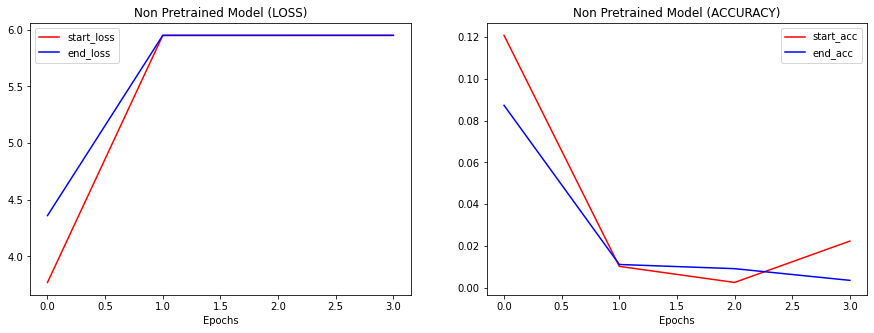

In [90]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(non_pretrained_df['start_loss'], 'r-', label='start_loss')
plt.plot(non_pretrained_df['end_loss'], 'b-', label='end_loss')
plt.title('Non Pretrained Model (LOSS)')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(non_pretrained_df['start_acc'], 'r-', label='start_acc')
plt.plot(non_pretrained_df['end_acc'], 'b-', label='end_acc')
plt.title('Non Pretrained Model (ACCURACY)')
plt.xlabel('Epochs')
plt.legend()

- Pretrained Model

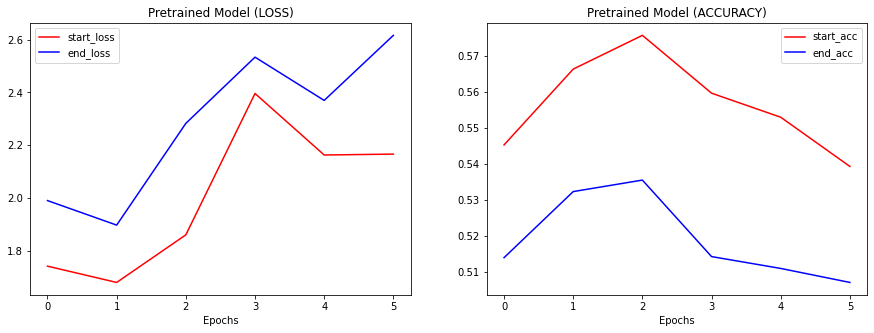

In [91]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(pretrained_df['start_loss'], 'r-', label='start_loss')
plt.plot(pretrained_df['end_loss'], 'b-', label='end_loss')
plt.title('Pretrained Model (LOSS)')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(pretrained_df['start_acc'], 'r-', label='start_acc')
plt.plot(pretrained_df['end_acc'], 'b-', label='end_acc')
plt.title('Pretrained Model (ACCURACY)')
plt.xlabel('Epochs')
plt.legend()

- Result

- Pretrained Model 을 활용한 모델의 결과를 보면, 각 질문에 대해 정확도 높은 답변을 해내는 모습을 확인할 수 있다.
<br>
<br>
- 하지만 답변의 상당 수에 '의' '은' 과 같은 조사가 포함되어 있어 정확한 단어만을 추출하지 못했음을 알 수 있고, 길이가 상당히 긴 답변을 생성하고 있는 경우도 확인되고 있다.
<br>
<br>
- 대체적으로 연도와 같은 숫자값을 찾아내 답변할 때 그 정확도가 높은 것을 알 수 있다.
<br>
<br>
- Non Pretrained Model 의 학습 그래프에서는 초기부터 Loss 가 급증한 뒤 더이상 감소하지 않는 모습을 확인할 수 있으며, Accuracy 또한 학습이 진행될수록 감소하는 양상을 띄고 있다.
<br>
<br>
- 반면, Pretrained Model 의 학습 그래프에서는 초기에 Loss 가 감소하다가 증가하는 모습을 확인할 수 있으며, Accuracy 또한 안정적으로 증가하다가 이후에 감소하는 모습을 보이고 있다.
<br>
<br>
- early stopping 을 사용하였기 때문에 학습이 강제적으로 종료되었지만, 꾸준히 학습을 진행시키면 전반적으로 Loss 가 감소하고, Accuracy 가 증가하는 모습을 보일 것으로 생각된다.
<br>
<br>
- Non Pretrained Model 의 Loss 는 6 점대, Accuracy 는 0.1 보다 낮은 값이 도출되고 있는 반면에 Pretrained Model 의 Loss 는 2 점대, Accuracy 는 0.5 이상의 값이 도출되고 있으므로 Pretrained Model 의 성능이 훨씬 높은 것을 확인할 수 있다.

# Retrospection

<h2 style="font-style:italic">2022.02.21 - [E-13]BERT_pretrained_model_KorQuAD</h2>

> 이번 프로젝트에서는 BERT pretrained model 을 활용하여 퀴즈를 풀어내는 모델을 구현하였습니다. 아래에서는 프로젝트를 진행하면서 어려웠던 점이나 알게된 점, 모호한 점에 대해 회고해보도록 하겠습니다.
***

**어려웠던 점**
<br>
<br>
- BERT 모델이 Decoder 가 없이 학습하여 퀴즈에 대한 정답을 출력할 수 있다는 점이 어려웠습니다. 일반적인 Transformer 모델에서는 3 개의 Attention Layer 를 활용하여 Encoder, Decoder 를 학습시키고 Decoder 에서 출력값을 추출합니다. 반면, BERT 모델에서는 Encoder 의 구조만을 활용하여 학습시키고 출력값을 받아낼 수 있습니다. 이러한 구조를 코드로 구현하고 이해하는 일이 어려웠습니다.
<br>
<br>
- BERT 모델의 입력 부분에서는 Token 과 Segment, Positional Embedding 이 더해지게 됩니다. Segment 는 두 문장을 입력으로 받았을 때, 각각의 문장을 구분하는 역할을 담당하는 데 Segment 의 필요성에 대해 많은 의문이 들었습니다. 전체 문장을 한 번에 입력받는 Encoder Input 의 구조 상, 각 문장을 구분하는 Segment 가 필요한 것이라면 기존의 Transformer 모델에는 Segment 가 존재하지 않았기 때문입니다.

**알게된 점**
<br>
<br>
- Pretrained Model 을 활용하는 것이 성능에 큰 영향을 미친다는 점에 대해 확인하였습니다. Pretrained Model 을 사용하지 않았을 때와 사용하였을 때를 비교하면, Loss 와 Accuracy 값이 큰 차이가 나는 것을 알 수 있습니다.
<br>
<br>
- Sequence 데이터를 처리하는 모델들의 현 트렌드는 모두 Attention 에 있다는 것을 알 수 있었습니다. RNN 부터 Transformer, BERT 에 이르기까지 Attention 만을 활용하여 좋은 성능의 다양한 NLP 모델들을 구현해낼 수 있었습니다.

**모호한 점**
<br>
<br>
- 아직 Attention 에 대한 기본적인 개념과 원리에 대해 모르고 있다는 생각이 들었습니다. 중요하게 반영해야 할 문장 내 단어들의 가중치를 구하는 Attention 이 각각의 모델에서 어떠한 목적으로 어떤 방식으로 활용되고 있는지에 대해 깊게 공부해나가야할 것 같습니다.
<br>
<br>
- Attention 을 이해하고 학습하는 일은 곧 Transformer 와 BERT 를 이해나가는 데 중요한 초석이 될 수 있을 것으로 생각합니다. 어려운 모델들이니만큼 Attention 에 대해 심도있게 공부하고, 그 개념을 단단히 다져야겠다는 생각이 들었습니다.
<br>
<br>
- 위의 과정을 통해 Transformer 나 BERT 모델의 구조와 원리를 이해하고 나면, 프로젝트를 진행하면서 느꼈던 다양한 의문들이 풀리게 될 것 같습니다. 예를 들면, BERT 모델에서 Encoder 의 Attention 만으로도 훌륭한 성능의 모델을 구현할 수 있었던 이유나 Segment 를 활용해 각 문장을 구분해내는 작업이 Transformer 에는 존재하지 않는 이유 등이 그 것입니다.